# Error Analysis

En esta notebook haremos análisis de error sobre nuestro modelo neuronal.

La idea es ver cómo se activan las neuronas de la LSTM, cuándo las compuertas se saturan, etc.


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Cargamos datos dev con anotaciones propias

In [2]:
df_dev = pd.read_csv("dev_with_annotations.es.csv", index_col="id")

df_dev = df_dev[df_dev["text"].notnull()]


Cargamos modelos de fasttext y ELMo

In [3]:
%%capture
from elmoformanylangs import Embedder
import fastText
import os


fasttext_model = fastText.load_model(os.path.expanduser("../../../WordVectors/UBA_w3_300.bin"))
elmo_embedder = Embedder("../../../models/elmo/es/")

In [4]:
elmo_embedder.sents2elmo(["esto es una prueba"]);

## GRU + Global Average Pooling

We use a model with a BiLSTM + an average pooling (this is controlled by the `pooling` argument to the ElmoModel)

In [5]:
from hate.nn import ElmoModel
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
max_length = 40

def MyRecClass(*args, **kwargs):
    kwargs.update({
        'activation': 'sigmoid'
    })
    
    return GRU(*args, **kwargs)

model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=elmo_embedder,
    recursive_class=CuDNNGRU,
    rnn_units=200, dropout=0.0,
    pooling='avg',
    tokenize_args = {
        "preserve_case": False,
        "deaccent": False,
        "reduce_len": True,
        "strip_handles": True,
        "alpha_only": False,
        "stem": False
    }
)

#model.load_weights("../../../models/lstm_elmo.h5")
print(model.summary())

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Elmo (InputLayer)               (None, 40, 1024)     0                                            
__________________________________________________________________________________________________
Fasttext (InputLayer)           (None, 40, 300)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 40, 1324)     0           Elmo[0][0]                       
                                                                 Fasttext[0][0]                   
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 40, 200)      915600      concatenate_1[0][0]              
__________

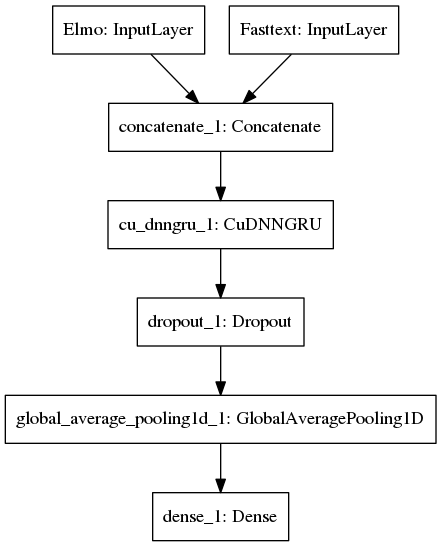

In [6]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [7]:

optimizer_args = {
    "lr": 0.001,
    "decay": 0.01,
}

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

¿Cómo anda el tokenizador?

In [8]:
from nltk.tokenize import TweetTokenizer

nltk_tokenizer = TweetTokenizer(
    preserve_case=False, reduce_len=True, strip_handles=True)
tweet_prueba = "jajajaAJAjaj qué hdy culi4w @mauriciomacri #HashTag"

print("Nuestro tokenizador: ", model._tokenizer.tokenize(tweet_prueba))
print("El de NLTK: ", nltk_tokenizer.tokenize(tweet_prueba))

Nuestro tokenizador:  ['jajajaajajaj', 'qué', 'hdy', 'culi', '4w', '#hashtag']
El de NLTK:  ['jajajaajajaj', 'qué', 'hdy', 'culi', '4w', '#hashtag']


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/lstm_model.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15)


model.fit(text_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(text_dev, y_dev), epochs=100, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 6s 1ms/step - loss: 0.6118 - acc: 0.6856 - val_loss: 0.4804 - val_acc: 0.7680

Epoch 00001: val_acc improved from -inf to 0.76800, saving model to /tmp/lstm_model.h5
Epoch 2/100
4500/4500 [==============================] - 1s 332us/step - loss: 0.4194 - acc: 0.8093 - val_loss: 0.4086 - val_acc: 0.8080

Epoch 00002: val_acc improved from 0.76800 to 0.80800, saving model to /tmp/lstm_model.h5
Epoch 3/100
4500/4500 [==============================] - 2s 348us/step - loss: 0.3530 - acc: 0.8433 - val_loss: 0.4066 - val_acc: 0.8140

Epoch 00003: val_acc improved from 0.80800 to 0.81400, saving model to /tmp/lstm_model.h5
Epoch 4/100
4500/4500 [==============================] - 2s 351us/step - loss: 0.3083 - acc: 0.8673 - val_loss: 0.3987 - val_acc: 0.8200

Epoch 00004: val_acc improved from 0.81400 to 0.82000, saving model to /tmp/lstm_model.h5
Epoch 5/100
4500/4500 [=======================

In [10]:
from hate.utils import print_evaluation
print("biGRU + MaxPool1D - Elmo+Embeddings -- \n\n")
print("Evaluación sobre dev")

model.load_weights(checkpointer.filepath)

print_evaluation(model, text_dev, y_dev)
print("\nEvaluación sobre test")

print_evaluation(model, text_test, y_test)

biGRU + MaxPool1D - Elmo+Embeddings -- 


Evaluación sobre dev
500/500 [==============================] - 0s 205us/step
Loss           : 0.5602
Accuracy       : 0.8340
Precision(1)   : 0.8009
Precision(1)   : 0.8625
Precision(avg) : 0.8317

Recall(1)      : 0.8333
Recall(0)      : 0.8345
Recall(avg)    : 0.8339

F1(1)          : 0.8168
F1(0)          : 0.8483
F1(avg)        : 0.8325

Evaluación sobre test
1600/1600 [==============================] - 0s 181us/step
Loss           : 0.9515
Accuracy       : 0.7269
Precision(1)   : 0.6339
Precision(1)   : 0.8279
Precision(avg) : 0.7309

Recall(1)      : 0.8000
Recall(0)      : 0.6755
Recall(avg)    : 0.7378

F1(1)          : 0.7073
F1(0)          : 0.7440
F1(avg)        : 0.7256


## Error Analysis

Vamos a ver los tweets con mayores errores

In [11]:
df_dev["proba"] = model.predict(text_dev)
df_dev["PROFANITY"] = 0


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 37
Falsos positivos: 46


,pred_true,pred_false
real,,
hs=1,185,37
hs=0,46,232


## Activations

Cortamos las otras capas, y vemos qué está saliendo de la capa recurrente. Para eso, armamos un modelo intermedio

In [12]:
from keras.models import Model
    

interm_model = Model(inputs=model.inputs, outputs=[model.recursive_layer])

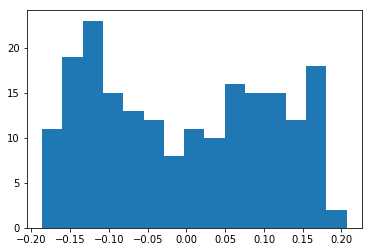

In [13]:
import matplotlib.pyplot as plt

kernel_weights, bias_weights = model.layers[-1].get_weights()

kernel_weights = np.sort(kernel_weights)

plt.hist(kernel_weights, bins=15);

*Observación*: 

Esta distribución cambia mucho si cambiamos la activación de la GRU/LSTM, y si ponemos max o average pooling


In [14]:
print("Mean weight {:.4f} STD: {:.4f}".format(kernel_weights.mean(), kernel_weights.std()))

Mean weight -0.0034 STD: 0.1115


In [25]:
(abs(kernel_weights) > 1.3 * kernel_weights.std() ).sum()

41

In [16]:
%matplotlib inline
import plotly.graph_objects as go

def get_interm_outputs(text):
    tokenized_text = model._preprocess_tweet(text)
    text_elmo, text_emb = model.preprocess_transform([text])
    
    rnn_output = interm_model.predict([text_elmo, text_emb]).squeeze()
    # Remove padding
    last_idx = next(j for j in range(len(tokenized_text), -1, -1) if tokenized_text[j-1] != '')
    return tokenized_text[:last_idx], rnn_output[:last_idx, :]
    
def plot_recurrent_outputs(text):
    tokenized_text, rnn_output = get_interm_outputs(text)
    kernel_weights, _ = model.layers[-1].get_weights()
    
    """
    Saturo para colores altos
    """
    ind = abs(kernel_weights) > 1.5* kernel_weights.std()
    kernel_weights = np.sign(kernel_weights) * ind + kernel_weights * (1-ind) 
    
    rnn_output = np.vstack([kernel_weights.reshape(1, -1), rnn_output])
    
    rnn_output = rnn_output.T
    print("Longitud de texto: {}".format(len(tokenized_text)))
    print("Matrix shape: {}".format(rnn_output.shape))
    print(tokenized_text)
    cell_idxs = list(range(rnn_output.shape[0] // 2))
    
    Z = rnn_output[cell_idxs]
    
    fig = go.Figure(
        data=go.Heatmap(
            z=Z,
            x=["WEIGHT"] + tokenized_text,
            colorscale='RdBu', reversescale=True
            
    ))
    fig.update_layout(
        autosize=False,
        width=1200,
        height=2000,
    )

    fig.show()



Agarramos un ejemplo y vemos la salida de las activaciones (recordar que son salidas de -1 a 1 porque son `tanh`)

- ~1 : rojo
- ~-1: azul

In [17]:
text = false_positives["text"].iloc[2]

In [26]:
rec = true_positives.iloc[9]
text = rec["text"]
print(rec["proba"])
print(text)

0.99628437
@VidalSieteDiez Tú eres la perra, no te dejes engañar.


In [27]:

tokenized_text = model._preprocess_tweet(text)
print(tokenized_text)
model.predict([text])

['tú', 'eres', 'la', 'perra', ',', 'no', 'te', 'dejes', 'engañar', '.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


array([[0.99625117]], dtype=float32)

Mmmm, esto 

Longitud de texto: 10
Matrix shape: (200, 11)
['tú', 'eres', 'la', 'perra', ',', 'no', 'te', 'dejes', 'engañar', '.']


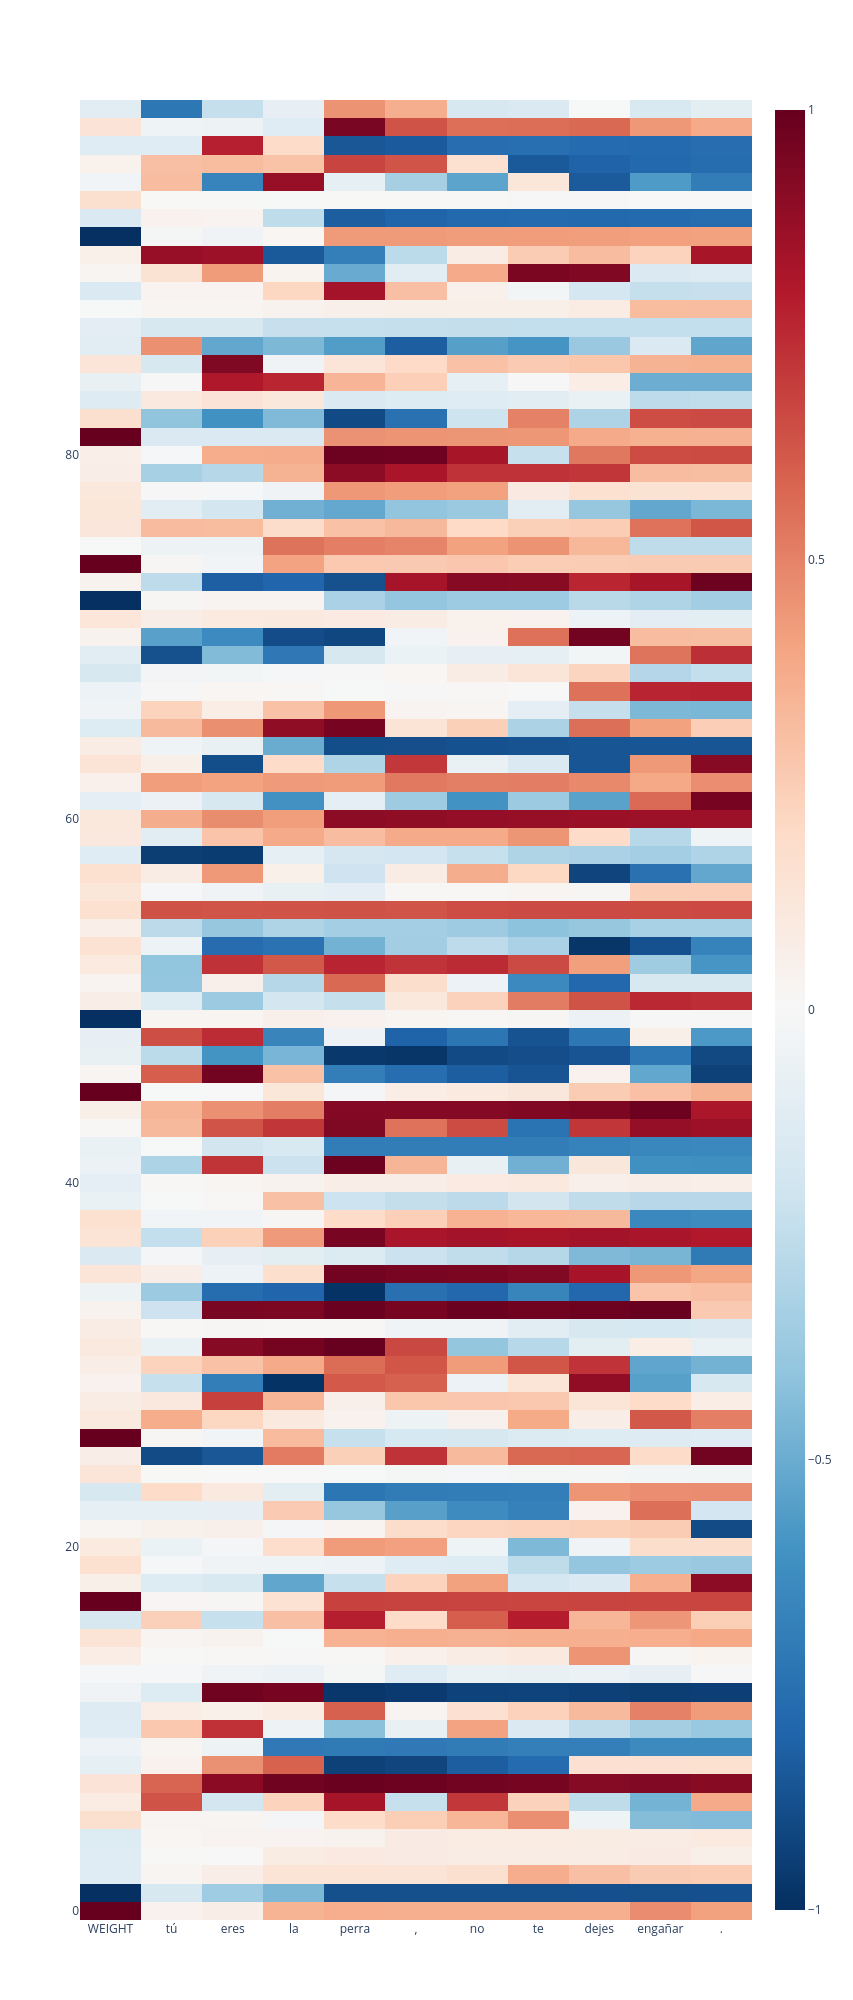

In [29]:
plot_recurrent_outputs(text)

Veamos el promedio de las activaciones (usando valor absoluto)

Promedio de valor abs. de activaciones de todas las LSTM Cell Forward


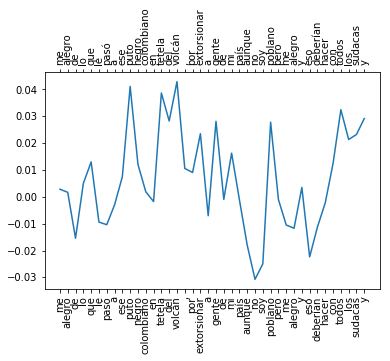

In [21]:

import matplotlib.pyplot as plt

tokens, output = get_interm_outputs(text)
plt.rcParams["xtick.labeltop"] = True
plt.rcParams["xtick.top"] = True

plt.plot(
    (output).mean(axis=1))

print("Promedio de valor abs. de activaciones de todas las LSTM Cell Forward")
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90);

## Proporción de Agresivos

In [22]:
print("Proporción de agresivos :", sum(df_dev["AG"] == 0) / len(df_dev))

hs = df_dev[df_dev["HS"] == 1]

print("Correlación AG - TR:", hs["AG"].corr(hs["TR"]))

Proporción de agresivos : 0.648
Correlación AG - TR: 0.42040512740887925


## Falsos negativos

Vamos a etiquetar la profanidad. Considero profanidad todo aquellas palabras de uso vulgar (puta, perra, zorra, coño, negratas, musulmonos) pero no así aquellas que sean marcadoras de discurso racista pero no vulgar (negro, subsahariano)

In [23]:
pd.set_option('max_colwidth', 400)



print("Totales = ", len(false_negatives))
print("No AG ({}) AG ({})".format(sum(false_negatives["AG"] == 0), sum(false_negatives["AG"] == 1)))
false_negatives[["text", "proba", "HS", "AG", "PROFANITY"]]

Totales =  37
No AG (13) AG (24)


,text,proba,HS,AG,PROFANITY
id,,,,,
24126,LA SOLUCIÓN ES SOLDARLE EL TIMÓN DE LA PATERA RUMBO DE DONDE SALIERON CON AGUA Y COMIDA. https://t.co/59pInBdgnR,0.003139,1.0,0.0,0
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.004725,1.0,1.0,0
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",0.005103,1.0,1.0,0
20175,"Ay Dios cuando se entere Casado de que la ola de calor viene dada por la entrada masiva, sin papeles, de aire subsahariano",0.007586,1.0,0.0,0
23688,"Ninguna mujer es tan santa como para no aprender a coger bien, ni tan puta como para no aprender a amar.",0.007630,1.0,1.0,0
22560,@CarlaEUrena @FelipeCalderon Callateeeee !! Puta gallina cacarea !! Ni idea tienes de nada .,0.017894,1.0,1.0,0
23019,"Tengo una sobrina que estaba re mal en química, tenía que dar una prueba global y fui a enseñarle y le fue la zorra, me siento tan bien",0.021647,1.0,1.0,0
20337,Ni armar un complot para matar un presidente saben... #Sudacas..,0.022175,1.0,1.0,0
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.023095,1.0,0.0,0


## Falsos Positivos

In [24]:
pd.set_option('max_colwidth', 300)



print("Totales = ", len(false_positives))
print("No AG ({}) AG ({})".format(sum(false_positives["AG"] == 0), sum(false_positives["AG"] == 1)))
false_positives[["text", "proba", "HS", "AG"]]

Totales =  46
No AG (46) AG (0)


,text,proba,HS,AG
id,,,,
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.999922,0.0,0.0
20148,Racismo es que hagas enfrijoladas con frijoles güeros y no negros.,0.999370,0.0,0.0
21892,@saancisco Callate puta tu eres el traidor.,0.998589,0.0,0.0
24180,Qué tan difícil es España cuando emigras sin papeles (por @EnriqueVasquez) https://t.co/yjZ4XV4QfU,0.997489,0.0,0.0
21497,Talvez quede como zorra pero te lo mereces Socia😎,0.996519,0.0,0.0
20952,@NicolasMaduro Callate la jeta perra que de este año no pasas,0.994375,0.0,0.0
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.993792,0.0,0.0
24172,"Y los que no se denuncian... hagamos números. El acoso a las mujeres es diario. No todos los hombres son acosadores, pero todas las mujeres han sido acosadas. https://t.co/jza9llhqWA",0.992105,0.0,0.0
20210,"@adrispears @7santy Tú eres la puta Beyoncé siempre, querido ❤",0.990800,0.0,0.0
